In [1]:
from stableVersion import _estimator, create_strategy_config, strategy_real_time_optimize

In [2]:
import threading
import sys
import pandas as pd
import platform
import numpy as np
from sklearn.model_selection import ParameterGrid
global RecursionBorder

if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"../testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)
# inpData = inpData.loc['2021-01-01':]
inpData

,open,high,low,close
time,,,,
2018-11-01 00:15:00,111.975,111.998,111.975,111.997
2018-11-01 00:16:00,111.997,112.000,111.995,111.996
2018-11-01 00:17:00,111.996,112.011,111.995,112.003
2018-11-01 00:18:00,112.003,112.004,111.981,111.982
2018-11-01 00:19:00,111.982,111.989,111.962,111.965
...,...,...,...,...
2021-11-13 00:55:00,123.669,123.672,123.660,123.665
2021-11-13 00:56:00,123.665,123.670,123.661,123.670
2021-11-13 00:57:00,123.670,123.673,123.657,123.660


In [3]:
RecursionBorder = 1000
grid_params = {
    # Оптимизировать !!!
    'yThreshold': [150],
    # Оптимизировать !
    'varianceRatioFilter': [0.85],
    'reverseVarianceRatioFilter': [1.0],
    # Оптимизировать !!
    'restAfterLoss': [324],
    # Оптимизировать !
    'restAfterFatProfit' : [1],
    # Оптимизировать !!
    'stopLossStdMultiplier': [108_00],
    # Оптимизировать !
    'takeProfitStdMultiplier': [4050],
    # Оптимизировать !!
    'varianceRatioCarreteParameter': [18],
    # Оптимизировать !!!
    'scanHalfTime': [1500],
    # Оптимизировать 0!
    'halfToFat': [3],
    # Оптимизировать 0!
    'halfToLight': [1],
    # Оптимизировать 0!
    'halfToTime': [1],
    }

grid_params = ParameterGrid(grid_params)
grid_params = pd.DataFrame(grid_params).sample(frac=1, random_state=9).reset_index(drop=True)

OPTIMIZATION:0:10080
0 of 0
TRADE:10080:30240
Position after trade period: 20769
OPTIMIZATION:10689:20769
0 of 0
TRADE:20769:40929
Position after trade period: 32373
OPTIMIZATION:22293:32373
0 of 0
TRADE:32373:52533
Position after trade period: 43817
OPTIMIZATION:33737:43817
0 of 0
ValueError 585
openIndex
6590    76.157704
Name: profit, dtype: float64
TRADE:43817:63977
Position after trade period: 54988
OPTIMIZATION:44908:54988
0 of 0
ValueError 585
openIndex
6706    26.045474
Name: profit, dtype: float64
TRADE:54988:75148
Position after trade period: 65808
TOTAL PNL =  -153.87903262177218
DD DIV TOTAL PNL =  -0.4043459303244352


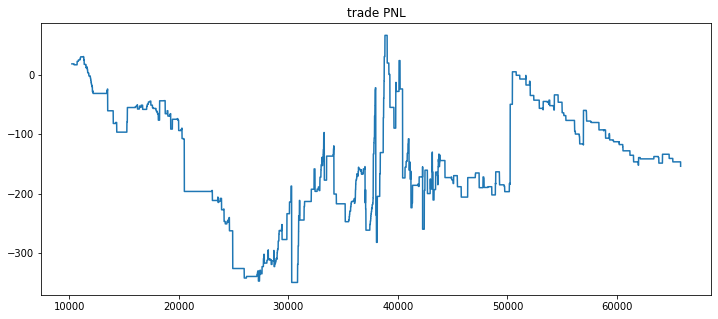

In [4]:
totalResult, RealTimeOptimizeTrades, paramsEvolution = strategy_real_time_optimize(realTimeData=inpData.iloc[450_000:890_000].copy(), parameters=create_strategy_config(grid_params.iloc[0]), show=True,
                                                                                   savePath='', update=False)

In [5]:
slippage = 2
trades = RealTimeOptimizeTrades[0]
for i in range(1, len(RealTimeOptimizeTrades)):
    trades = trades.append(RealTimeOptimizeTrades[i], ignore_index=True)
trades['profit'] = (trades["position"] * (trades["closePrice"] -
                                    trades["openPrice"]) - slippage
                 if (trades["typeOperation"] == 'BUY').bool
                 else abs(trades["position"]) * (trades["openPrice"] -
                                              trades["closePrice"]) - slippage)
trades['own_time'] = trades['closeIndex'] - trades['openIndex']
trades.groupby(by='typeHolding').describe().profit

,count,mean,std,min,25%,50%,75%,max
typeHolding,,,,,,,,
endPeriod,31.0,-41.322726,64.463296,-214.245096,-62.514330,-32.872196,-19.166268,134.680522
fatExtraProfit,1.0,7.483905,NaN,7.483905,7.483905,7.483905,7.483905,7.483905
lightCross,219.0,1.491421,14.747577,-47.030386,-2.075207,0.022250,3.840167,77.449361
lightCrossEmergent,186.0,5.306454,11.982103,-47.787372,-0.778793,2.349017,7.655836,66.397535
stopLoss,45.0,-4.310670,15.365580,-28.707950,-13.776248,-7.407560,-2.178920,54.753778


In [6]:
import matplotlib.pyplot as plt
trades

,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex,profit,own_time
0,BUY,178.193,112.238,10237,102.075,116.490,lightCross,112.353647,10387,18.607435,150
1,SELL,-178.025,112.344,10432,115.977,111.112,lightCrossEmergent,112.341523,10687,-1.559038,255
2,BUY,178.086,112.305,10711,109.289,113.513,lightCrossEmergent,112.348953,10718,5.827361,7
3,SELL,-178.020,112.347,10826,114.131,111.657,lightCrossEmergent,112.322766,10837,2.314144,11
4,SELL,-178.080,112.309,10962,114.057,111.638,lightCrossEmergent,112.292320,10981,0.970374,19
...,...,...,...,...,...,...,...,...,...,...,...
477,SELL,-180.104,111.047,63814,111.088,111.028,stopLoss,111.088000,63819,-9.384264,5
478,BUY,180.252,110.956,64146,111.050,110.974,stopLoss,111.050000,64172,14.943688,26
479,BUY,180.440,110.840,64756,110.812,110.853,stopLoss,110.812000,64758,-7.052320,2
480,BUY,180.413,110.857,65090,110.836,110.867,stopLoss,110.836000,65091,-5.788673,1


In [7]:

# totalResult, RealTimeOptimizeTrades, paramsEvolution = strategy_real_time_optimize(realTimeData=inpData.iloc[0:400_000].copy(), parameters=create_strategy_config(grid_params.iloc[0]), show=True,
                                                                                   savePath='', update=False)

IndentationError: unexpected indent (1130132792.py, line 2)

In [ ]:
slippage = 2
trades = RealTimeOptimizeTrades[0]
for i in range(1, len(RealTimeOptimizeTrades)):
    trades = trades.append(RealTimeOptimizeTrades[i], ignore_index=True)
trades['profit'] = (trades["position"] * (trades["closePrice"] -
                                    trades["openPrice"]) - slippage
                 if (trades["typeOperation"] == 'BUY').bool
                 else abs(trades["position"]) * (trades["openPrice"] -
                                              trades["closePrice"]) - slippage)
trades['own_time'] = trades['closeIndex'] - trades['openIndex']

In [ ]:
trades.groupby(by='typeHolding').describe().profit

In [ ]:
trades[trades.typeHolding == 'stopLoss']

In [ ]:
import matplotlib.pylab as plt

plt.figure(figsize=(12,7))
plt.style.use('Solarize_Light2')
plt.title('MarkOut')
plt.hlines(y=0, xmin=0, xmax=max(trades['own_time']), colors='red')
plt.plot(trades.groupby(by='own_time').profit.mean() / 20_000, '--')
plt.show()

In [ ]:
plt.plot(inpData.iloc[:400_000].copy().open)

In [ ]:
_estimator(_DATAFRAME=inpData.iloc[20_000:30_000].copy(),
           _gridParams=create_strategy_config(grid_params.iloc[0]),
           show=True)

In [ ]:
totalResult, RealTimeOptimizeTrades, paramsEvolution = strategy_real_time_optimize(realTimeData=inpData.iloc[:400_000].copy(), parameters=create_strategy_config(grid_params.iloc[0]), show=True)